In [1]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
df= pd.read_csv('Data/train.csv')
#df = df[:100]
all_id = np.array(df['Id'])
len(all_id)

9912

In [5]:
IMG_SIZE = 128
colours = 3


In [6]:
def get_images_from_id(data_id, img_size=128, colours=3):
    pictures = np.zeros((len(data_id), IMG_SIZE, IMG_SIZE, colours))
    for i, single_id in tqdm.tqdm(enumerate(data_id)):
        img = cv2.cvtColor(cv2.imread(f"Data/train/{single_id}.jpg"), cv2.COLOR_BGR2RGB)
        new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        pictures[i] = new_img/255
    return pictures
#     plt.imshow(pictures[i])
#     plt.savefig(f'picture{i}.png')

In [7]:
X_train_full_id, X_test_id, y_train_full, y_test = train_test_split(all_id, df['Pawpularity'], test_size=0.2, random_state=42)
X_train_id, X_valid_id, y_train, y_valid = train_test_split(X_train_full_id, y_train_full, test_size=0.25, random_state=42)

In [8]:
X_train_metadata = df[df['Id'].isin(X_train_id)]
X_train_pictures = get_images_from_id(X_train_metadata['Id'])
X_train_metadata = X_train_metadata.drop(columns=['Id'])

X_test_metadata = df[df['Id'].isin(X_test_id)]
X_test_pictures = get_images_from_id(X_test_metadata['Id'])
X_test_metadata = X_test_metadata.drop(columns=['Id'])

X_valid_metadata = df[df['Id'].isin(X_valid_id)]
X_valid_pictures = get_images_from_id(X_valid_metadata['Id'])
X_valid_metadata = X_valid_metadata.drop(columns=['Id'])
X_train_metadata.shape[1]

5946it [00:46, 128.74it/s]
1983it [00:15, 124.81it/s]
1983it [00:15, 124.73it/s]


13

In [9]:
tf.random.set_seed(42)

input_image = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3)) # Wejście na zdjęcia 128X128x3
input_metadata = tf.keras.Input(X_train_metadata.shape[1]) # Wejście na metadane 13 kategorii

image_conv2D_1 = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same')(input_image)
image_conv2D_2 = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same')(image_conv2D_1)
image_maxpool2D_1 = tf.keras.layers.MaxPooling2D(2)(image_conv2D_2)

image_conv2D_3 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(image_maxpool2D_1)
image_conv2D_4 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(image_conv2D_3)
image_maxpool2D_2 = tf.keras.layers.MaxPooling2D(2)(image_conv2D_4)

image_conv2D_5 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(image_maxpool2D_2)
image_conv2D_6 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(image_conv2D_5)
image_maxpool2D_3 = tf.keras.layers.MaxPooling2D(2)(image_conv2D_6)

image_conv2D_7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(image_maxpool2D_3)
image_conv2D_8 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(image_conv2D_7)
image_maxpool2D_4 = tf.keras.layers.MaxPooling2D(2)(image_conv2D_8)

image_conv2D_9 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(image_maxpool2D_4)
image_conv2D_10 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(image_conv2D_9)
image_maxpool2D_5 = tf.keras.layers.MaxPooling2D(2)(image_conv2D_10) 
flatten = tf.keras.layers.GlobalAveragePooling2D()(image_maxpool2D_5) #Podobne działanie do Flatten

metadata_dense_1 = tf.keras.layers.Dense(16)(input_metadata)
metadata_dense_2 = tf.keras.layers.Dense(16)(metadata_dense_1)
metadata_dense_3 = tf.keras.layers.Dense(16)(metadata_dense_2)
metadata_dense_4 = tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2())(metadata_dense_3)

concat = tf.keras.layers.concatenate([flatten, metadata_dense_4])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_image, input_metadata], outputs=[output])
tf.keras.utils.plot_model(model, show_shapes=True)





# model_2 = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]),
#     tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='relu')
# ])

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=["mse"])

history_1 = model.fit((X_train_pictures,X_train_metadata), y_train, epochs=50, validation_data=((X_valid_pictures, X_valid_metadata), y_valid))

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Train on 5946 samples, validate on 1983 samples
Epoch 1/50
5946/5946 [==============================] - 11s 2ms/sample - loss: 485.5304 - mse: 485.4052 - val_loss: 458.5341 - val_mse: 458.4301
Epoch 2/50
5946/5946 [==============================] - 6s 1ms/sample - loss: 428.4567 - mse: 428.3625 - val_loss: 525.2681 - val_mse: 525.1813
Epoch 3/50
5946/5946 [==============================] - 6s 1ms/sample - loss: 424.1227 - mse: 424.0396 - val_loss: 451.2584 - val_mse: 451.1786
Epoch 4/50
5946/5946 [==============================] - 6s 1ms/sample - loss: 423.5323 - mse: 423.4546 - val_loss: 450.0515 - val_mse: 449.9758
Epoch 5/50
5946/5946 [==============================] - 6s 1ms/sample - loss: 419.4030 - mse: 419.3286 - val_loss: 449.9097 - val_mse: 449.8365
Epoch 6/50
5946/5946 [==============================] - 6s 1ms/sample - loss: 419.1281 - mse: 419.0560 - val_loss: 459.8825 - val_mse: 459.8112
E

In [10]:
mean_squared_error(y_test, model.predict((X_test_pictures, X_test_metadata)))

450.6174485709307

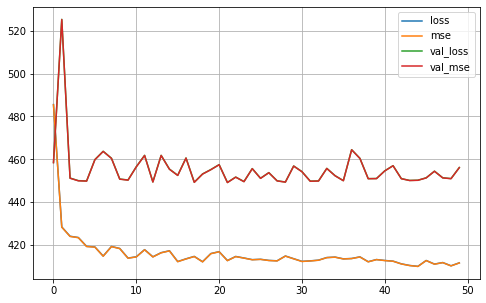

In [11]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()